In [2]:
import sys
sys.path.append("../")

from scripts.direct_training import direct_training
from scripts.fine_tuning import fine_tuning

pre_trained = direct_training.to_dataframe(
    config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        n_train=10_000,
    )
)

pre_trained_models = {row.labels: row.id for row in pre_trained.itertuples()}
pre_trained_models

{'ace': '23.06.08-20.33.15-394025',
 'gap20': '23.06.09-08.13.03-677890',
 'edip': '23.06.09-22.16.54-046769',
 'lcbop': '23.06.13-08.37.46-604921'}

In [3]:
data_limits = dict(
    low=25,
    high=3_200,
)

fine_tuned_models = {}

for key, limit in data_limits.items():

    df = fine_tuning.to_dataframe(
        config=dict(
            finetune_dataset="C-GAP-17",
            n_finetune=limit,
        )
    )
    df = df[df.pretrain_id.isin(pre_trained_models.values())]
    # get best model (as measured by force rmse) for each pretrain_id
    best_ft = df.groupby("pretrain_id").apply(
        lambda df: df.sort_values("test_force_rmse").iloc[0]
    ).reset_index(drop=True)

    # get pretrain labels
    best_ft["pt_labels"] = best_ft.pretrain_id.apply(
        lambda pretrain_id: next(
            k for k, v in pre_trained_models.items() if v == pretrain_id
        )
    )
    fine_tuned_models[key] = dict(zip(best_ft.pt_labels, best_ft.id))

fine_tuned_models

{'low': {'ace': '23.07.08-17.02.22-705827',
  'gap20': '23.06.09-19.53.51-386470',
  'edip': '23.07.08-06.57.08-287772',
  'lcbop': '23.07.10-09.13.24-606333'},
 'high': {'ace': '23.07.07-12.13.12-079327',
  'gap20': '23.07.08-04.06.18-341979',
  'edip': '23.07.08-08.51.11-843085',
  'lcbop': '23.07.10-10.41.49-851157'}}

In [4]:
from src.data import get_file_path, ensure_dataset_exists
from ase.io import read
import numpy as np


def get_test_set_labels(source):
    ensure_dataset_exists("C-GAP-17", source)
    test_set = get_file_path("C-GAP-17", source, "test")
    structures = read(test_set, ":")
    prefix = f"{source}_" 
    predictions = []
    for structure in structures:
        pred = {
            "energy": structure.info[f"{prefix}energy"],
            "forces": structure.arrays[f"{prefix}force"],
        }
        predictions.append(pred)
    return predictions

labels = {
    source: get_test_set_labels(source)
    for source in ("ace", "gap20", "edip", "lcbop", "dft")
}

In [5]:
from src.evaluate import get_model_predictions

test_structures = read("data/processed/C-GAP-17/dft/test.extxyz", ":")

pre_trained_predictions = {
    label: get_model_predictions(id, test_structures)
    for label, id in pre_trained_models.items()
}

fine_tuned_predictions = {
    key: {
        label: get_model_predictions(id, test_structures)
        for label, id in values.items()
    } for key, values in fine_tuned_models.items()
}

In [6]:
def energies_and_forces(predictions):
    N = np.array([len(s["forces"]) for s in predictions])
    ref_energies = np.array([s["energy"] for s in predictions]) / N
    ref_forces = np.vstack([s["forces"] for s in predictions])
    # subtract arbitrary offset
    e0 = np.mean(ref_energies)
    ref_energies -= e0

    return ref_energies, ref_forces

force_labels = {
    label: energies_and_forces(predictions)[1]
    for label, predictions in labels.items()
}

pre_trained_forces = {
    label: energies_and_forces(predictions)[1]
    for label, predictions in pre_trained_predictions.items()
}

fine_tuned_forces = {
    key: {
        label: energies_and_forces(predictions)[1]
        for label, predictions in values.items()
    } for key, values in fine_tuned_predictions.items()
}

In [7]:
def angle_error(forces1, forces2):
    unit_a = forces1 / np.linalg.norm(forces1 + 1e-8, axis=1)[..., None]
    unit_b = forces2 / np.linalg.norm(forces2 + 1e-8, axis=1)[..., None]
    return np.mean(np.arccos(np.clip((unit_a * unit_b).sum(axis=1), -1, 1)))

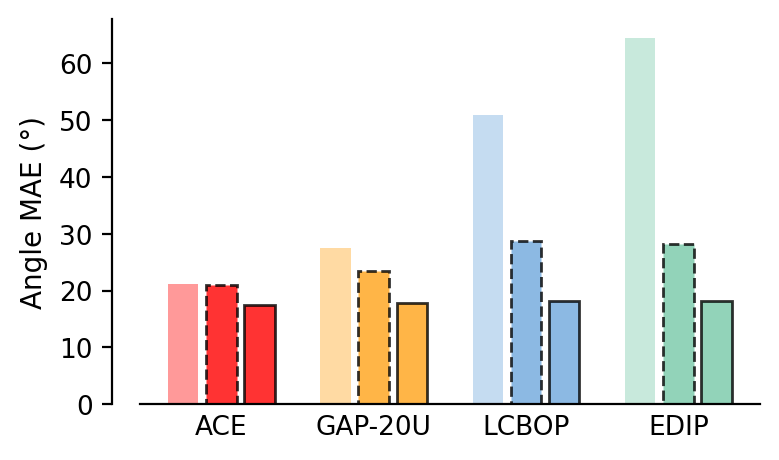

In [14]:
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, colours
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(style_defaults)

plt.figure(figsize=(4, 2.5))
for i, label in enumerate(("ace", "gap20", "lcbop", "edip")):
    angle_error_to_dft = {
        key: angle_error(force_labels["dft"], forces[label])
        for key, forces in fine_tuned_forces.items()
    }

    angle_error_pretrained_to_dft = angle_error(
        force_labels["dft"], pre_trained_forces[label]
    )

    w = 0.2
    s = 0.25


    plt.bar(
        i-s,
        np.rad2deg(angle_error_pretrained_to_dft),
        facecolor=colours[label],
        alpha=0.4,
        width=w,
    )
    plt.bar(
        i,
        np.rad2deg(angle_error_to_dft["low"]),
        facecolor=colours[label],
        edgecolor="black",
        linestyle="dashed",
        width=w,
        alpha=0.8,
    )
    plt.bar(
        i+s,
        np.rad2deg(angle_error_to_dft["high"]),
        facecolor=colours[label],
        edgecolor="black",
        width=w,
        alpha=0.8,
    )

plt.xticks(range(4), ("ACE", "GAP-20U", "LCBOP", "EDIP"))
# set xtick lengths to zero
plt.gca().tick_params(axis="x", length=0)
plt.gca().spines["left"].set_position(("outward", 10))
plt.ylabel("Angle MAE (°)")

plt.savefig("../figures/correlation-dft.svg", bbox_inches="tight", transparent=True)

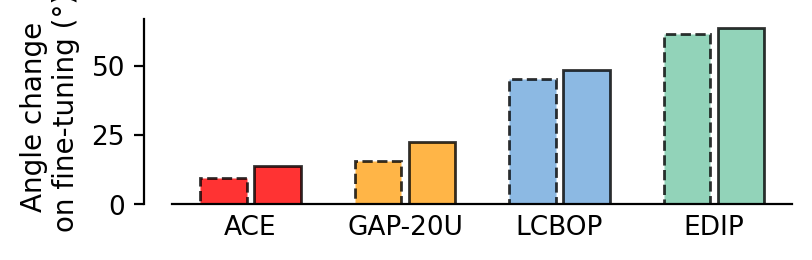

In [16]:
plt.figure(figsize=(4, 1.2))
for i, label in enumerate(("ace", "gap20", "lcbop", "edip")):
    angle_error_to_pretrained = {
        key: angle_error(pre_trained_forces[label], forces[label])
        for key, forces in fine_tuned_forces.items()
    }

    w = 0.3
    s = 0.35

    plt.bar(
        i-s/2,
        np.rad2deg(angle_error_to_pretrained["low"]),
        facecolor=colours[label],
        edgecolor="black",
        linestyle="dashed",
        width=w,
        alpha=0.8,
    )
    plt.bar(
        i+s/2,
        np.rad2deg(angle_error_to_pretrained["high"]),
        facecolor=colours[label],
        edgecolor="black",
        width=w,
        alpha=0.8,
    )


plt.xticks(range(4), ("ACE", "GAP-20U", "LCBOP", "EDIP"))
plt.gca().tick_params(axis="x", length=0)
plt.gca().spines["left"].set_position(("outward", 10))
plt.ylabel("Angle change \non fine-tuning (°)")


plt.savefig("../figures/correlation-pretrained.svg", bbox_inches="tight", transparent=True)